*Prepared for the course "TDPS22: Data Science Programming" at Jönköping University, Teacher: [Marcel Bollmann](mailto:marcel.bollmann@ju.se)*

# Exercise 5: Statistical Modeling & Advanced Topics

This notebook contains advanced exercises on machine learning and statistical modeling, focusing on Scikit-learn and Pingouin.  We'll look at three topics in particular: how to determine _feature importance_ in a classifier; how to perform basic statistical modeling and run statistical tests; and how to do dimensionality reduction.

For the first parts, we'll continue using the Penguins dataset; for dimensionality reduction, we will look at an example with English word vectors.

### Learning Goals

- Know how to _find and apply functions_ related to statistical modeling, testing, model inspection, and more.
- Know how to _perform dimensionality reduction_ of high-dimensional data with Scikit-learn.

In [230]:
try:
    from rich import load_ipython_extension
    %load_ext rich
except ImportError:
    try:
        from rich import pretty
        pretty.install()
    except ImportError:
        pass

In [231]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns

sns.set()

In [232]:
# Load a predefined dataset from Seaborn
df = sns.load_dataset("penguins").dropna()
df = df.join(pd.get_dummies(df["species"]))  # one-hot encoding for species
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,Adelie,Chinstrap,Gentoo
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,1,0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,1,0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,1,0,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,1,0,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,1,0,0
...,...,...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female,0,0,1
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,0,0,1
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,0,0,1
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,0,0,1


- - - 
## Permutation feature importance

We'll keep working with the Penguins dataset first – I hope you're not getting bored of these little guys yet!

In Exercise 4, we trained a bunch of classifiers where I told you which input features to train on.  The last task we ended with was: *Can we predict the sex of a penguin just from knowing its body mass and species?*  We tried to improve our model, and you probably ended up with a classifier that could do this reasonably well, but not perfectly.

Now, we ask a different question: **Which input features are particularly helpful/important for predicting the _sex_ of a penguin?** This is _feature importance._

We'll try to implement a particular algorithm for feature importance here, called **permutation feature importance**.  Its core idea is simple: for a given feature (say, _body mass_), shuffle the feature column (so that every penguin randomly gets a _body mass_ from another penguin), and see how the classifier accuracy changes.  If it drops a lot, the feature was probably important; if it stays the same, the feature didn't matter.  This method is attractive because it **_works with any model_** (including neural networks of all kinds) and **_it's fast_** (because it doesn't require retraining any part of the model), so it's really good to know about!

### Useful Resources

For more information about the algorithm:

+ ["Permutation Feature Importance" from _Interpretable Machine Learning_ by Christoph Molnar](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

For how to implement this in Scikit-learn:

+ [`sklearn.inspection.permutation_importance`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) from the _Scikit-learn documentation_


- - -
Let's start by defining our input and target features, as well as the model:

In [233]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

X = df[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
        "Adelie",
        "Chinstrap",
        "Gentoo",
    ]
]
y = df["sex"]
model = SVC(C=1.0, gamma=0.0001, kernel="rbf")

**1. Make a train/test split, train the model, and calculate its accuracy on the test set.** This should be familiar from Exercise 4.

In [234]:
# YOUR CODE HERE
df_filtered = df.drop(columns=["species", "island"])
train_df, test_df = train_test_split(df_filtered, test_size=0.2, shuffle=True)
X_train = train_df.drop(columns=["sex"])
y_train = train_df["sex"]

X_test = test_df.drop(columns=["sex"])
y_test = test_df["sex"]


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy", accuracy_score(y_test, y_pred))


Accuracy 0.7611940298507462


**2. Calculate permutation importance over the input features.** Look at the _mean_ importance across 50 repeats. Try to answer the questions:

  - **Which feature is the most important for the classifier?**
  - **Which features (if any) are not important at all?**

In [235]:
# YOUR CODE HERE
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X, y, n_repeats=50, random_state=0)
print(result.importances_mean)
print(result.importances_std)
print(X.columns[2], X.columns[3])
print(X.columns[0], X.columns[1])

[ 0.          0.         -0.00132132  0.29063063  0.          0.
  0.        ]
[0.         0.         0.00226005 0.02518437 0.         0.
 0.        ]
flipper_length_mm body_mass_g
bill_length_mm bill_depth_mm


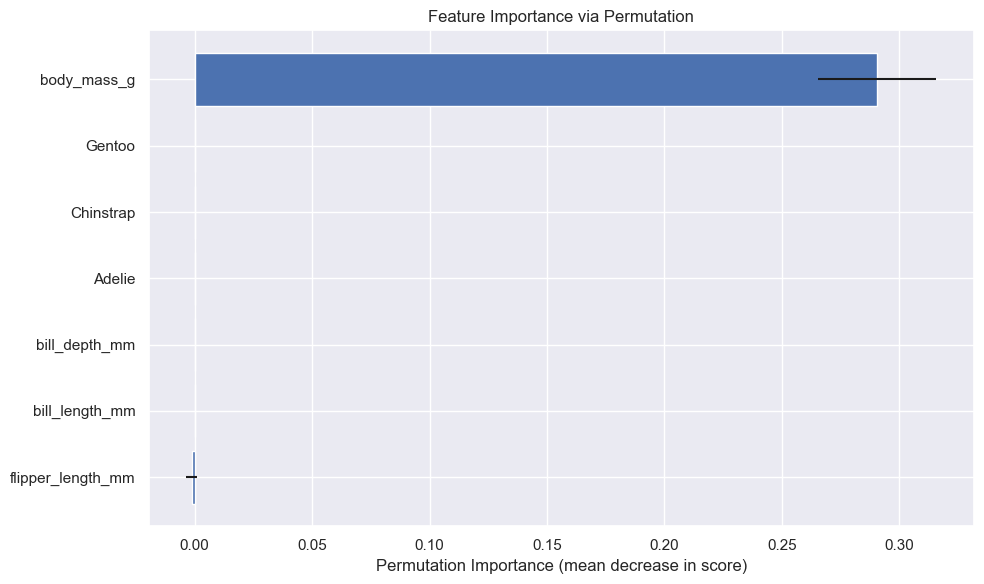

In [236]:
feature_names = X.columns
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)),
         result.importances_mean[sorted_idx],
         xerr=result.importances_std[sorted_idx],
         align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Permutation Importance (mean decrease in score)")
plt.title("Feature Importance via Permutation")
plt.tight_layout()
plt.show()

**3. Change your train/test data** (e.g. `X_train`, `X_test`) **to only include the _two most important features_.** Then retrain the model with that & evaluate it again. Did the accuracy score change?

In [237]:
# YOUR CODE HERE
df_filtered = df[['flipper_length_mm', 'body_mass_g', 'sex']]
train_df, test_df = train_test_split(df_filtered, test_size=0.2, shuffle=True)

X_train = train_df.drop(columns=['sex'])
y_train = train_df['sex']

X_test = test_df.drop(columns=['sex'])
y_test = test_df['sex']

model = SVC(C=1.0, gamma=0.0001, kernel="rbf")
model.fit(X_train, y_train)
y_pred_good = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_good))

Accuracy: 0.7910447761194029


**4. Do the same thing, but train the model on the _two least important features only_.** What accuracy score do you expect? See if the result matches your expectation.

In [238]:
# YOUR CODE HERE
df_filtered = df[['bill_length_mm', 'bill_depth_mm', 'sex']]
train_df, test_df = train_test_split(df_filtered, test_size=0.2, shuffle=True)

X_train = train_df.drop(columns=['sex'])
y_train = train_df['sex']

X_test = test_df.drop(columns=['sex'])
y_test = test_df['sex']

model = SVC(C=1.0, gamma=0.0001, kernel="rbf")
model.fit(X_train, y_train)
y_pred_bad = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_bad))

Accuracy: 0.582089552238806


**5. What accuracy score would you get if you always guessed the majority class?** In other words, determine which sex (Male or Female) is represented more often in the training set, make a list of "guesses" that only contain this majority class label, and calculate its accuracy score on the test set. How does it compare to the accuracy of your classifier from Q4?

In [239]:
# YOUR CODE HERE
male = pd.DataFrame(["Male" for _ in range(len(y))])
female = pd.DataFrame(["Female" for _ in range(len(y))])

y_pred_majority = pd.DataFrame(["Male" for _ in range(len(y_test))])

print("Male Accuracy:", accuracy_score(y, male))
print("Female Accuracy:", accuracy_score(y, female))

Male Accuracy: 0.5045045045045045
Female Accuracy: 0.4954954954954955


We'll come back to these models we trained here in a bit, so keep your predictions around.

- - - 
## Statistical testing

Statistical testing, particularly hypothesis testing, is an important aspect of data-driven research.  You have heard about certain statistical hypothesis tests, such as the _t-test_ the _Wilcoxon signed rank test_, in the "Evaluation" lecture of the Data Science course. You will also likely hear some more about it in the Research Methods course. We don't have time to go into details about _when to select which statistical test and why_, so we will focus on _how to run_ such tests here.

As mentioned in the lecture, there are _many_ ways to do statistical testing and modeling in Python. You will often see people using [the `scipy.stats` module](https://docs.scipy.org/doc/scipy/reference/stats.html) or [the `statsmodels` library](https://www.statsmodels.org/stable/index.html), but we will mainly look at [Pingouin](https://pingouin-stats.org/) here, as it is extremely simple to use & get started with.

### Useful Resources

+ [Pingouin Quick Start](https://pingouin-stats.org/index.html#quick-start) _(take a look at the "10 minutes to Pingouin" section!)_



Let's take a subset of our dataset, and look at **female Gentoo penguins** only:

In [240]:
df_sub = df[(df["species"] == "Gentoo") & (df["sex"] == "Female")].drop(
    ["Adelie", "Chinstrap", "Gentoo"], axis=1  # drop the one-hot columns
)

**6. Which of our measurement variables are _normally distributed_?** Checking for a normal distribution is useful, because it is often a requirement for using other metrics that the data is normally distributed.

In [241]:
# YOUR CODE HERE
import pingouin as pg
print(pg.normality(df_sub))

                          W      pval  normal
bill_length_mm     0.989448  0.895108    True
bill_depth_mm      0.985902  0.735957    True
flipper_length_mm  0.973945  0.244979    True
body_mass_g        0.981331  0.510659    True


**7. Which of the measurement variables are _correlated_?** Perform a pairwise correlation analysis with all the columns of our dataframe. Use Pearson correlation if the variables are normally distributed, and Spearman correlation if not.

In [242]:
# YOUR CODE HERE
pg.pairwise_corr(df_sub, method="pearson")

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,bill_length_mm,bill_depth_mm,pearson,two-sided,58,0.430444,"[0.19, 0.62]",0.000744,42.013,0.930621
1,bill_length_mm,flipper_length_mm,pearson,two-sided,58,0.206881,"[-0.05, 0.44]",0.119192,0.536,0.347700
2,bill_length_mm,body_mass_g,pearson,two-sided,58,0.271926,"[0.01, 0.5]",0.038930,1.311,0.549401
3,bill_depth_mm,flipper_length_mm,pearson,two-sided,58,0.307793,"[0.05, 0.52]",0.018752,2.425,0.661617
4,bill_depth_mm,body_mass_g,pearson,two-sided,58,0.371881,"[0.13, 0.57]",0.004048,9.212,0.831143
5,flipper_length_mm,body_mass_g,pearson,two-sided,58,0.487618,"[0.26, 0.66]",0.000103,254.704,0.978399


**8. Make a new Pandas DataFrame with "classifier correctness" labels.** This DataFrame should have:

- One **column per classifier**, e.g. the "good" classifier from Q3, the "bad" classifier from Q4, and the "majority" classifier from Q5.
- One **row per instance in your test set**.
- A value of **`True` or `False` in each cell**, depending on whether the classifier _(column)_ correctly classified the instance _(row)_ or not.

Your resulting DataFrame could look something like this:

|       | **good** | **bad**  | **majority** |
|-------|----------|----------|--------------|
| **0** | True     | False    | False        |
| **1** | True     | False    | False        |
| **2** | True     | True     | True         |
| ...   | ...      | ...      | ...          |

In [244]:
# y_pred_good = pd.DataFrame(y_pred_good)
# y_pred_bad = pd.DataFrame(y_pred_bad)
# y_test = pd.DataFrame(y_test)

# print(y_test.shape)
# print(y_pred_good.shape)
# print(y_pred_bad.shape)
# print(y_pred_majority.shape)

# y_test       = y_test.drop("index", axis=1)
# y_pred_good  = y_pred_good.drop("index", axis=1)
# y_pred_bad   = y_pred_bad.drop("index", axis=1)
# y_pred_majority = y_pred_majority.drop("index", axis=1)

# print(y_test.columns)
# print(y_pred_good.columns)
# print(y_pred_bad.columns)
# print(y_pred_majority.columns)

# print(np.array_equal(y_test.values, y_pred_good.values))

In [243]:
# df_eval = pd.DataFrame(
#     np.transpose([y_pred_good == y_test, y_pred_bad == y_test, y_pred_majority == y_test]),
#     columns=["good", "bad", "majority"],
# )
# df_eval

**9. Is the "bad" model (from Q4) still significantly better than the "majority" class model (from Q5)?**

We want to answer this question by using **McNemar's test,** using a significance level of $0.05$.  This means that if McNemar's test gives us a $p$-value $< 0.05$, we accept that there is a significant difference between our two classifiers.  If you use [Pingouin's implementation of McNemar's test](https://pingouin-stats.org/generated/pingouin.chi2_mcnemar.html), you will find that the DataFrame from Q6 is exactly what we need to use with Pingouin!

In [14]:
# YOUR CODE HERE

**10. Is the "good" model (from Q3) significantly better than the "bad" model (from Q4)?**  Same as above, just comparing different columns.

In [15]:
# YOUR CODE HERE

- - - 
## Dimensionality reduction

So far, our data only had a few variables at a time. For high-dimensional data, e.g. weights learned by a neural network, _dimensionality reduction_ techniques can come in useful to perform analyses. Here, we look at two such techniques–**principal component analysis (PCA)** and **t-distributed stochastic neighbor embedding (t-SNE)**–and how to perform them in Python.

For this, we'll load another dataset that comes from a neural network: a small subset of the [GloVe pre-trained word vectors for English](https://nlp.stanford.edu/projects/glove/). It contains vector representations of almost 3,000 English words where each vector has a dimensionality of 50. _(The full GloVe dataset covers 400,000 words and offers up to 300-dimensional vectors.)_ Our goal is to learn something about what these vectors actually encode.

### Useful Resources

+ ["PCA as dimensionality reduction"](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html#PCA-as-dimensionality-reduction) from the _Python Data Science Handbook_
+ [How to use t-SNE effectively](https://distill.pub/2016/misread-tsne/)

Another useful library for this kind of task is [HyperTools](https://github.com/ContextLab/hypertools), which I don't discuss here, but you may of course also use!

In [245]:
glove = pd.read_csv("data/glove.subset.50d.txt", sep=" ", header=None, index_col=0)
glove.index.name = "word"
glove

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
word,,,,,,,,,,,,,,,,,,,,,
a,0.217050,0.465150,-0.467570,0.10082,1.013500,0.74845,-0.531040,-0.262560,0.168120,0.131820,...,0.138130,0.369730,-0.642890,0.024142,-0.039315,-0.260370,0.12017,-0.043782,0.410130,0.17960
abandon,0.456430,-0.501790,0.082902,-0.72677,-0.362920,-0.02104,-0.167750,0.625280,-0.259540,0.281720,...,-0.180080,-0.921530,0.381290,0.023647,0.375840,-0.057270,-0.30060,0.383230,-0.355470,-0.14419
ability,0.135230,-0.241440,0.584420,-0.15259,0.528840,0.23586,0.441880,0.366560,0.827030,0.750210,...,-0.060980,-0.125100,-0.052429,0.444010,0.000073,-0.211810,0.44934,0.385050,-0.354570,0.20372
able,0.864540,-0.390890,0.980690,-0.43311,0.544040,-0.31648,-0.321860,0.832060,-0.053605,0.100040,...,0.050596,-0.215260,0.402560,0.326370,0.069126,-0.048120,0.17884,-0.138790,-0.225270,0.23315
abortion,-0.150790,-0.330830,-0.494370,-1.00370,-0.498520,2.27160,-0.110920,-0.703130,0.581470,0.446610,...,-0.407510,0.212580,-0.025393,1.659600,0.322240,0.100850,-0.57467,-0.172060,-0.052021,0.76517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
your,-0.029163,0.817690,0.384700,-0.77857,1.104900,-0.13655,-0.024691,-0.051103,0.779500,0.051357,...,0.686590,-0.302940,-0.551750,0.964660,0.053103,-0.084807,0.85120,-0.541860,0.324530,0.58425
yours,0.055450,0.181130,0.791160,-0.39936,0.644360,-0.25559,0.198670,0.145580,-0.153710,0.568930,...,0.150870,-1.105800,-0.013501,0.009074,-0.225070,0.313430,-0.69607,-0.590710,-0.162260,0.82532
yourself,-0.125310,-0.410110,0.304610,-0.93852,0.765590,-0.12585,0.203160,0.338310,0.133250,0.543080,...,0.349380,-0.791710,0.114520,0.899400,0.266480,0.092037,0.37759,-0.420590,0.578560,0.69841


**11. Perform a principal component analysis (PCA) to map the GloVe vectors into 2-dimensional space.** Two dimensions are a common choice to make them suitable for visualization.

If you are using Scikit-learn to do this, you will find that the 2-dimensional vectors are returned as a NumPy array.

- **Also merge this back into a DataFrame that has the actual words as an index again**, just like above!

In [247]:
# YOUR CODE HERE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
glove_pca = pca.fit_transform(glove)
glove_pca

array([[-0.35699696, -1.10587658],
       [ 0.90012942,  0.7261655 ],
       [ 1.21313851,  1.21328674],
       ...,
       [-1.19789845,  2.29407559],
       [ 0.29932915, -0.14047001],
       [ 0.2932737 , -1.92598511]])

In [248]:
glove_pca = pd.DataFrame(glove_pca)
glove_pca["word"] = glove.index
glove_pca = glove_pca.set_index("word")
glove_pca

,0,1
word,,
a,-0.356997,-1.105877
abandon,0.900129,0.726166
ability,1.213139,1.213287
able,0.522769,0.635880
abortion,1.324263,1.135266
...,...,...
your,-1.294936,1.490597
yours,-1.551149,2.172142
yourself,-1.197898,2.294076


**12. Plot some 2-dimensional word vectors using the following function.**  It defines some words in some categories, takes _the first two dimensions_ and plots them as a scatterplot, along with labels of the actual words.

If you created your DataFrame in Q10 correctly, you should just need to call this function on your transformed DataFrame.

In [249]:
def plot_words(df):
    """This function takes a DataFrame with a word index
    and plots some chosen example words of different categories."""

    word_cats = {
        "food": ["apple", "orange", "lemon", "tomato", "potato", "chocolate", "bread", "butter"],
        "transport": ["car", "train", "rail", "plane", "bike", "boat", "ship", "foot"],
        "pronouns": ["he", "she", "it", "they", "them", "you", "your", "us"],
    }
    fig, ax = plt.subplots()
    pal = sns.color_palette("bright")
    for i, (category, words) in enumerate(word_cats.items()):
        for word in words:
            pos = df.loc[word].iloc[0], df.loc[word].iloc[1]
            ax.scatter(*pos, color=pal[i])
            ax.annotate(word, pos, color=pal[i])

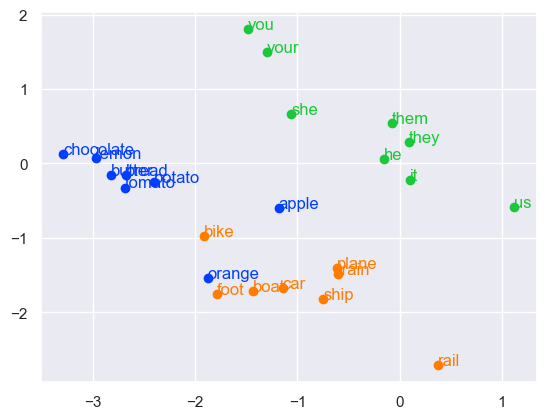

In [250]:
# YOUR CODE HERE
plot_words(glove_pca)

**13. Perform a t-SNE transformation and plot it as well!**  Scikit-learn also provides this algorithm as [`sklearn.manifold.TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), and you can use it exactly the same way as PCA. This is both powerful and dangerous – you don't really need to "know" anything about the algorithm to use it!

In [253]:
# YOUR CODE HERE

from sklearn.manifold import TSNE

tsne = TSNE()
glove_tsne = tsne.fit_transform(glove)
glove_tsne

array([[ -4.3222504, -28.318296 ],
       [ 27.371323 ,  -3.8040955],
       [ 19.707357 ,  15.135052 ],
       ...,
       [ -7.6919103, -13.048232 ],
       [ 28.539398 , -30.320124 ],
       [-27.510374 , -50.082405 ]], dtype=float32)

In [ ]:
glove_tsne = pd.DataFrame(glove_tsne)
glove_tsne["word"] = glove.index
glove_tsne = glove_tsne.set_index("word")
glove_tsne


,0,1
word,,
a,-4.322250,-28.318296
abandon,27.371323,-3.804096
ability,19.707357,15.135052
able,9.059367,-15.503889
abortion,45.272068,22.234259
...,...,...
your,-4.050421,-13.701384
yours,-11.431533,-11.247150
yourself,-7.691910,-13.048232


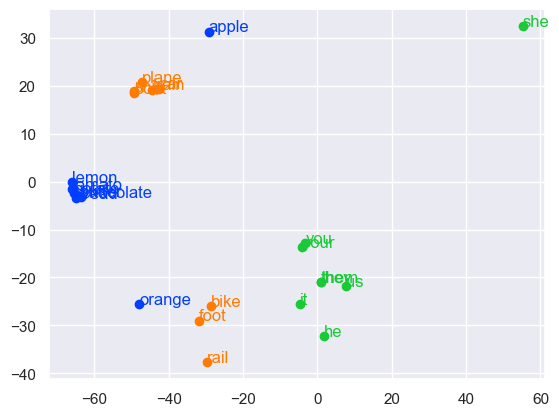

In [255]:
plot_words(glove_tsne)

**14. Repeat the t-SNE plot with different random states and perplexity values.** t-SNE is a very powerful and useful technique, but it is sensitive to hyperparameters. I strongly recommend you to read [How to use t-SNE effectively](https://distill.pub/2016/misread-tsne/) if you ever want to use it in practice.

For now, let's just see what happens if we change the `random_state` or the `perplexity` (the default is 30, and the authors recommend to try values between 5 and 50.)

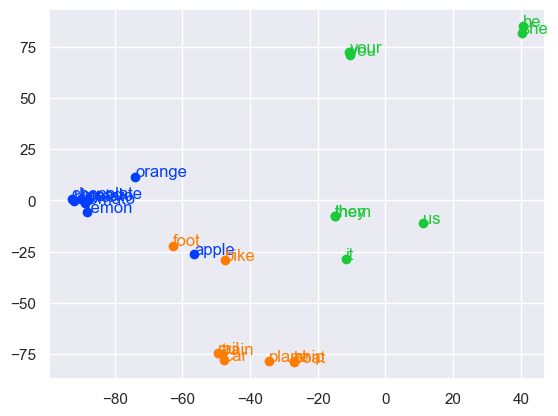

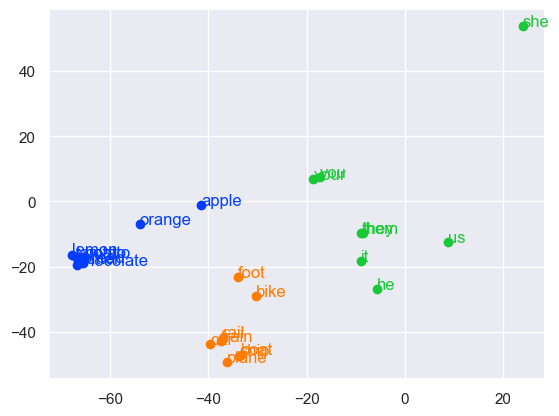

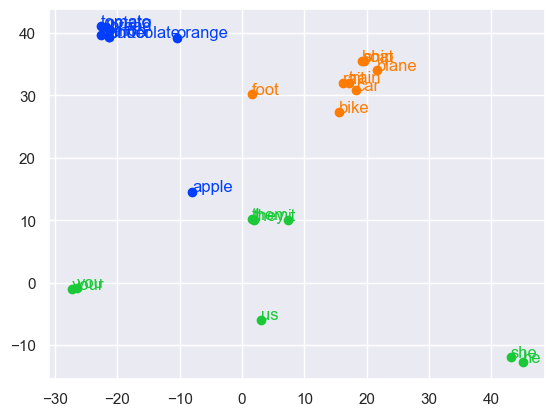

In [256]:
# YOUR CODE HERE
random_state = [0, 5, 10]
perplexity = [5, 30, 50]

for i in range(len(random_state)):
    tsne = TSNE(perplexity=perplexity[i], random_state=random_state[i])
    glove_tsne = tsne.fit_transform(glove)
    
    glove_tsne = pd.DataFrame(glove_tsne)
    glove_tsne["word"] = glove.index
    glove_tsne = glove_tsne.set_index("word")

    plot_words(glove_tsne)